## TripAdvisor Recomender System

#### Data Collection from TripAdvisor

All the data are scraped using Selenium and BeautifulSoup from TripAdvisor website from late April to early May 2019. The hotels are from 16 popular European tourist destination cities and their TripAdvisor rating range from 3.0 to 5.0. The collected data are separated into 4 files. These files are:

1) tripadvisor_data.csv (hotel information from the hotel listings from the city section)

2) tripadvisor_hotel.txt (hotel information from the hotel details webpage in json format)

3) tripadvisor_reviewer.csv (brief reviewer information from the hotel details webpage)

4) tripadvisor_hotel_review.csv (reviews written by reviewer from the TripAdvisor reviewer webpage)

In [1]:
# import libraries  
from selenium import webdriver
from bs4 import BeautifulSoup 
import urllib
import requests, re
from datetime import datetime
import time as t
from time import time
import os, sys
from lxml import html, etree
import argparse

import pandas as pd
import numpy as np
import random
import json
from collections import defaultdict
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore,  BaselineOnly, CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import dump
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

### Scraping through TripAdvisor City Section for Hotel Listings

In [ ]:

def process_hotel_list(locality, checkin_date, checkout_date, hotel_data, sort="popularity"):
    
    """
    
    Args:
        locality is the city location of the hotel search

        checkin_date and checkout_date are the start and end date of hotel stay.
        It should be year/month/day string format, ie. '2019/07/01'

        sort is the method of how search results are displayed either by order of 'popularity', 'value', 'price' or 'distance'

        hotel_data is a list used to collect scraped hotel information which will be returned back by the function.
    
    """
    
    check_in = checkin_date
    check_out = checkout_date
    
    geo_url = 'https://www.tripadvisor.com/TypeAheadJson?action=API&startTime='+str(int(time()))+'&uiOrigin=GEOSCOPE&source=GEOSCOPE&interleaved=true&types=geo,theme_park&neighborhood_geos=true&link_type=hotel&details=true&max=12&injectNeighborhoods=true&query='+locality
    api_response  = requests.get(geo_url, verify=False).json()
    url_from_autocomplete = "http://www.tripadvisor.com"+api_response['results'][0]['url']
    geo = api_response['results'][0]['value'] 
    date = check_in+"_"+check_out
    
    form_data = {'changeSet': 'TRAVEL_INFO',
                'showSnippets': 'false',
                'staydates':date,
                'uguests': '2',
                'sortOrder':sort
    
                }
    
    headers = {
                'Accept': 'text/javascript, text/html, application/xml, text/xml, */*',
                'Accept-Encoding': 'gzip,deflate',
                'Accept-Language': 'en-US,en;q=0.5',
                'Cache-Control': 'no-cache',
                'Connection': 'keep-alive',
                'Content-Type': 'application/x-www-form-urlencoded; charset=utf-8',
                'Host': 'www.tripadvisor.com',
                'Pragma': 'no-cache',
                'Referer': url_from_autocomplete,
                'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:28.0) Gecko/20100101 Firefox/28.0',
                'X-Requested-With': 'XMLHttpRequest'
                }
    
    cookies=  {"SetCurrency":"USD"}
    page_response  = requests.post(url = url_from_autocomplete,data=form_data,headers = headers, cookies = cookies, verify=False)
    if page_response.status_code != 200:
        print('Page error for, '+ url_from_autocomplete +', is found.')
        return hotel_data
    else:
        parser = html.fromstring(page_response.text)
        hotel_data = iterate_hotels(parser, locality, hotel_data)
        return hotel_data
    
    
    
def iterate_hotels(parser, locality, hotel_data):
    
    """
    
    this function is called by process_hotel_list() in order to parse and scrape hotel information
    
    """
    
    # checks to see if more search results are available in the next page of pagination and then retrieve results
    next_page = parser.xpath('//a[contains(@class,"nav next taLnk ui_button primary")]/@href')
    next_page = 'http://www.tripadvisor.com' + next_page[0].replace('#BODYCON','') if next_page else  None
    print("Processing content from " + next_page)
    
    # filter to the div tag where matching hotel search results are found
    hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[contains(@class,"listing collapsed")]')
    if not hotel_lists:
        hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[@class="listing "]')

    for index, hotel in enumerate(hotel_lists): # grab the element of each feature from html
        XPATH_HOTEL_LINK = './/a[contains(@class,"property_title")]/@href'
        XPATH_REVIEWS  = './/a[@class="review_count"]//text()'
        XPATH_RANK = './/div[@class="popRanking"]//text()'
        XPATH_RATING = './/a[contains(@class,"ui_bubble_rating")]//@alt'
        XPATH_HOTEL_NAME = './/a[contains(@class,"property_title")]//text()'
        XPATH_HOTEL_FEATURES = './/div[contains(@class,"common_hotel_icons_list")]//li//text()'
        XPATH_HOTEL_PRICE = './/div[contains(@data-sizegroup,"mini-meta-price")]/text()'
        XPATH_VIEW_DEALS = './/div[contains(@data-ajax-preserve,"viewDeals")]//text()' 
        XPATH_BOOKING_PROVIDER = './/div[contains(@data-sizegroup,"mini-meta-provider")]//text()'

        raw_booking_provider = hotel.xpath(XPATH_BOOKING_PROVIDER)
        raw_no_of_deals =  hotel.xpath(XPATH_VIEW_DEALS)
        raw_hotel_link = hotel.xpath(XPATH_HOTEL_LINK)
        raw_no_of_reviews = hotel.xpath(XPATH_REVIEWS)
        raw_rank = hotel.xpath(XPATH_RANK)
        raw_rating = hotel.xpath(XPATH_RATING)
        raw_hotel_name = hotel.xpath(XPATH_HOTEL_NAME)
        raw_hotel_features = hotel.xpath(XPATH_HOTEL_FEATURES)
        raw_hotel_price_per_night  = hotel.xpath(XPATH_HOTEL_PRICE)

        # parse through html code to obtain the relevant information with some data cleaning also
        url = 'http://www.tripadvisor.com'+raw_hotel_link[0] if raw_hotel_link else  None
        reviews = ''.join(raw_no_of_reviews).replace("reviews","").replace(",","") if raw_no_of_reviews else 0 
        rank = ''.join(raw_rank) if raw_rank else None
        rating = ''.join(raw_rating).replace('of 5 bubbles','').strip() if raw_rating else None
        name = ''.join(raw_hotel_name).strip() if raw_hotel_name else None
        hotel_features = ','.join(raw_hotel_features)
        price_per_night = ''.join(str(*raw_hotel_price_per_night)).replace('\n','') if raw_hotel_price_per_night else None
        no_of_deals = re.findall("all\s+?(\d+)\s+?",''.join(raw_no_of_deals))
        booking_provider = ''.join(raw_booking_provider).strip() if raw_booking_provider else None

        if no_of_deals:
            no_of_deals = no_of_deals[0]
        else:
            no_of_deals = 0

        data = {
                'hotel_name':name,
                'url':url,
                'locality':locality,
                'reviews':reviews,
                'tripadvisor_rating':rating,
                'hotel_features':hotel_features,
                'price_per_night':price_per_night,
                'no_of_deals':no_of_deals,
                'booking_provider':booking_provider

                }
        hotel_data.append(data)
        
    if next_page: #get search results from next page
        t.sleep(1)
        try:
            page_response = requests.get(next_page)
        except requests.exceptions.ConnectionError: # try reconnecting after one minute
            t.sleep(60)
            page_response = requests.get(next_page)
            parser = html.fromstring(page_response.text)
            hotel_data = iterate_hotels(parser, locality, hotel_data)
        else: #if no exceptions is raised, parse the html response
            parser = html.fromstring(page_response.text)
            hotel_data = iterate_hotels(parser, locality, hotel_data)
        finally:
            return hotel_data
        
    return hotel_data


In [ ]:
hotel_data = []

In [ ]:
hotel_data = process_hotel_list('London, England', '2019/07/01', '2019/07/15', hotel_data)
# the information collected in tripadvisor_data.csv is for hotel stay period between July 1, 2019 and July 15, 2019.
# the date parameter is used to determine room rates for our data

In [ ]:
# write hotel_data to a csv file called tripadvisor_data.csv
# with open('tripadvisor_data.csv','wb')as csvfile:  # substitute 'wb' for 'ab' to append hotel_data to existing tripadvisor_data.csv
            fieldnames = ['hotel_name','url','locality','reviews','tripadvisor_rating','price_per_night','booking_provider','no_of_deals','hotel_features']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for row in hotel_data:
                writer.writerow(row)

In [ ]:
tadata = pd.read_csv('tripadvisor_data.csv')
tadata.info()

In [ ]:
tadata = tadata.drop_duplicates() # drop duplicate hotels from list
# tadata.to_csv("tripadvisor_data.csv", index=False, encoding='utf8')

### Scraping through Individual TripAdvisor Hotel Webpage for Hotel Details

In [ ]:

def process_hotel_details(hotel_url, retry=0):
    
    """
    
    Args:
        hotel_url is hotel webpage at TripAdvisor
        retry attempts to reconnect to TripAdvisor if it fails up to MAX_RETRY times
    
    """
    
    MAX_RETRY = 10
    RETRY = 0

    headers = {
                "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
                "accept-encoding": "gzip, deflate, br",
                "accept-language": "en-GB,en;q=0.9,en-US;q=0.8,ml;q=0.7",
                "cache-control": "max-age=0",
                "upgrade-insecure-requests": "1",
                "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/71.0.3578.80 Chrome/71.0.3578.80 Safari/537.36",
                }

    response = requests.get(hotel_url, headers=headers)
    if response.status_code == 404:
        print('error: Page not found, status_code: 404')
        continue
    parser = html.fromstring(response.text, myurl)

    XPATH_NAME = '//h1[@id="HEADING"]//text()'
    XPATH_RANK = '//span[contains(@class,"popularity")]//text()'
    XPATH_FULL_ADDRESS_JSON = '//script[@type="application/ld+json"]//text()'

    # filter html code using xpath to obtain relevant hotel information
    raw_name = parser.xpath(XPATH_NAME)
    raw_rank = parser.xpath(XPATH_RANK)
    raw_address_json = parser.xpath(XPATH_FULL_ADDRESS_JSON)
    name = clean(raw_name)
    rank = clean(raw_rank)
    if not name:
        if RETRY < MAX_RETRY:
            RETRY = RETRY+1
            # Retrying the same URL with request
            process_hotel_details(hotel_url, RETRY)

    hotel_rating = 0
    review_count = 0
    address = {}
    if raw_address_json:
        try:
            parsed_address_info = json.loads(raw_address_json[0])
            rating = parsed_address_info.get('aggregateRating', {})
            address = parsed_address_info.get("address", {})

            hotel_rating = rating.get('ratingValue')
            review_count = rating.get('reviewCount')

            address = {
                        'street_address': address.get('streetAddress'),
                        'region': address.get('addressRegion'),
                        'locality': address.get('addressLocality'),
                        'country': address.get("addressCountry", {}).get("name"),
                        'zipcode': address.get("postalCode")
                    }
        except Exception as e:
            review_count = hotel_rating = 0
            raise e

    ratings = {} # get the tally of how users rated the given hotel ie. 'excellent': 28 users' 
    elems = parser.find_class("hotels-review-list-parts-ReviewRatingFilter__row_num--gIW_f")
    if elems:
        ratings = {
            'Excellent': elems[0].text,
            'Good': elems[1].text,
            'Average': elems[2].text,
            'Poor': elems[3].text,
            'Terrible': elems[4].text
                }

    amenities = parser.find_class("hotels-hotel-review-about-with-photos-Amenity__name--2IUMR")
    amenity_list = []     
    for a in amenities:
        amenity_list.append(a.text)

    data = {
            'address': address,
            'ratings': ratings,
            'amenities': amenity_list,
            'rating': float(hotel_rating) if hotel_rating else 0.0,
            'review_count': int(review_count) if review_count else 0,
            'name': name,
            'rank': rank,
            'hotel_url': hotel_url
            }

    return data


def clean(text):
    
    """
    
    processing scraped information before adding to a json formatted list of dictionaries
    
    """
    
    if text:
        # Removing \n \r and \t
        return ' '.join(''.join(text).split()).strip()
    return None


In [ ]:
hotel_details = []
for index, hotel in enumerate(tadata['url'][0:1000]):
    result = process_request(hotel)
    hotel_details.append(result)
    print(index)  # keeping track of progress in case of error
    t.sleep(1)

In [ ]:
details = []
details.extend(hotel_details)

In [ ]:
# saving details list as tripadvisor_hotel.txt in json format
# with open('tripadvisor_hotel.txt', 'w') as out_file:
    json.dump(details, out_file)

In [ ]:
# converting tripadvisor_hotel.txt to pandas DataFrame
tahotel = pd.read_json('tripadvisor_hotel.txt')
tahotel = tahotel[tahotel.review_count >= 100]   # filtering hotels with more than 100 reviews 
tahotel.index = range(len(tahotel))

### Scraping through Individual TripAdvisor Hotel Webpage for Guest Review Information

In [ ]:

def process_reviews(hotel_url, reviewer_list):
    
    """
    
    hotel_url is hotel webpage at TripAdvisor
    reviewer_list is a continuing list of guest review information scraped from the tripadvisor webpage
    
    """
    
    response = requests.get(hotel_url)
    if response.status_code != 200:
        print('Error is found on page, '+ hotel_url)
        return reviewer_list
    else:
        soup = BeautifulSoup(response.text)
        reviews = soup.findAll(class_ = 'hotels-review-list-parts-SingleReview__reviewContainer--d54T4')
        review_count = 10
        reviewer_list = iterate_review_page(soup, reviews, review_count, reviewer_list)
        return reviewer_list
            
def iterate_review_page(soup, reviews, review_count, reviewer_list):
    
    """
    
    this function is called by process_reviews to parse relevant user information.
    
    """

    # checks to see if there are more results found in the next page of pagination
    next_page = soup.find('a', class_="ui_button nav next primary ", href=True)
    next_page = 'http://www.tripadvisor.com'+next_page['href'] if next_page['href'] else  None
       
    for r in reviews:
        try:
            # finds out how many reviews that user has contributed to tripadvisor
            contribute = r.find('span', class_ = 'social-member-MemberHeaderStats__bold--3z3qh').get_text()
            contribute = int(contribute.replace(',', '')) 
        except AttributeError:
            contribute = 0    
            pass
        
        if contribute > 25 and review_count > 0: #filter reviewer with more than 25 reviews and a limit of 10 reviewers for each hotel
            try:
                reviewer = r.find('a', class_ = 'ui_header_link social-member-event-MemberEventOnObjectBlock__member--35-jC').get_text()
            except AttributeError:
                reviewer = " ANONYNOUS USER: NONE PROVIDED"
                
            reviewer_website = r.find('a', href=True)
            reviewer_website = 'http://www.tripadvisor.com'+reviewer_website['href']
            rating = r.find('span', class_="ui_bubble_rating")
            rating = str(rating).strip('"0></span>')[-1:]
            try:
                date =  r.find(class_ = 'hotels-review-list-parts-EventDate__event_date--CRXs4').find('span').get_text()
            except:
                date = 'NOT AVAILABLE'
            
            if reviewer_website not in list(reviewer_list['user_link']): # avoid duplicate reviewer
                
                df = pd.DataFrame({'uid':reviewer, 'user_link':reviewer_website, 'rating':int(rating), 'date_of_stay':date[14:], 'num_of_reviews':int(contribute)}, 
                                  columns=['uid', 'user_link', 'rating', 'date_of_stay', 'num_of_reviews'], index=[0])
                reviewer_list = pd.concat([reviewer_list, df], axis =0)   
                review_count -= 1
            else:
                pass
    if next_page and review_count > 0:
        t.sleep(1)
        try:
            response = requests.get(next_page)
        except requests.exceptions.ConnectionError:
            t.sleep(60) # Retrying same url after 1 minute
            response = requests.get(next_page)
            soup = BeautifulSoup(response.text)
            reviews = soup.findAll(class_ = 'hotels-review-list-parts-SingleReview__reviewContainer--d54T4')
            reviewer_list = iterate_review_page(soup, reviews, review_count, reviewer_list)
        else: # execute this portion when try clause is successful
            soup = BeautifulSoup(response.text)
            reviews = soup.findAll(class_ = 'hotels-review-list-parts-SingleReview__reviewContainer--d54T4')
            reviewer_list = iterate_review_page(soup, reviews, review_count, reviewer_list)
        finally:
            return reviewer_list

    return reviewer_list



In [ ]:
reviewer_list = [] # please remember to initialize only once. data will be lost if it is initialized again

In [ ]:
for index, hotel in enumerate(tahotel[0:1000]['hotel_url']):
    hotel_url = hotel
    print(index) # keeping track of progress in case of error
    n = len(reviewer_list)
    hotel_df = process_reviews(hotel_url, reviewer_list)
    reviewer_list = pd.concat([reviewer_list, hotel_df[:][n:]], axis =0) # updates reviewer_list after getting results from process_reviews
    t.sleep(1)

In [ ]:
reviewer_list.to_csv('tripadvisor_reviewer.csv', index=False)

### Scraping through TripAdvisor Guest Reviewer Webpage for Hotel Reviews using Selenium

In [ ]:

def process_other_reviews(user_url, hotel_review_list):
    
    '''
    
    Args:
    user_url is the tripadvisor url for the reviewer information webpage
    hotel_review_list is the pandas dataframe that collects all parsed reviews information
    
    '''
    
    driver.get(user_url)
    t.sleep(1.5)
    try: # check if driver get user_url page
        response = driver.page_source
        hotel_review_list = try_button(driver, response, user_url, hotel_review_list)   
    except: # retry getting user_url with Selenium
        driver.get(user_url)
        t.sleep(1.5)
        try:
            response = driver.page_source
        except Exception as e: # print reason for why it fails
            print(e)
        else: # check if 'show more' button is clickable
            hotel_review_list = try_button(driver, response, user_url, hotel_review_list)
            
    return hotel_review_list
 

def try_button(driver, response, user_url, hotel_review_list):   
    
    """
    
    this function is called by process_other_reviews function to check if there is a 'show more' button to expand the reviews
    
    """
    
    try:
        python_button = driver.find_element_by_class_name("social-show-more-ShowMore__button_contents--1djai")
        python_button.click()
        soup = BeautifulSoup(response)
        hotel_review_list = iterate_reviewer_page(soup, user_url, hotel_review_list)
    except:
        soup = BeautifulSoup(response)
        hotel_review_list = iterate_reviewer_page(soup, user_url, hotel_review_list)
        
    return hotel_review_list

    
def iterate_reviewer_page(soup, user_url, hotel_review_list):  # filter out reviews that are not of hotels from the 16 european cities 
    
    """
    
    this function is called by try_button function to isolate reviews of hotels from the 16 european cities.
    
    """
    
    reviews = soup.findAll('div', class_ = 'social-sections-CardSection__card_section--3Hc9Y ui_card section')
    for r in reviews:
        hotel = r.find('div', class_="social-sections-POICarousel__container--297jy social-sections-POICarousel__carousel--1vz03").find('a', href=True)
        if not hotel:
            continue
        try:
            hotel = hotel['href']    # grab website link info
        except:
            continue
        if "Hotel_Review" in hotel:    # check if it is a hotel review and from the 16 cities
            if 'London_England.html' in hotel: # the search can be modified to other cities by visiting tripadvisor website to obtain the reference for a specific city
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Paris_lle_de_France.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Rome_Lazio.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Barcelona_Catalonia.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Berlin.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Vienna.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Prague_Bohemia.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Budapest_Central_Hungary.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Athens_Attica.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Florence_Tuscany.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Milan_Lombardy.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Madrid.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Lisbon_District_Central_Portugal.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Edinburgh_Scotland.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Amsterdam_North_Holland_Province.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Brussels.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            else:
                pass
            
    return hotel_review_list


def scrape_reviews(r, user_url, hotel_review_list, hotel):
    
    """
    
    this function is called by iterate_reviewer_page function to parse reviews
    
    """
    
    reviewer = r.find('a', class_ = 'ui_link social-member-event-MemberEventOnObjectBlock__member--35-jC').get_text()
    try:
        title = r.find('div', class_="social-sections-ReviewSection__title--35ISZ social-sections-ReviewSection__linked--2rTun").get_text()
    except:
        title = ''
    try:
        preview = r.find('q', class_="social-sections-ReviewSection__quote--3gE7d").get_text()
    except:
        preview = ''
    rating = r.find('span', class_="ui_bubble_rating")
    rating = str(rating).strip('"0></span>')[-1:]
    hotel = 'http://www.tripadvisor.com' + hotel
    try:
        date =  r.find('div', class_ = 'social-review-info-EventDate__event_date--2d3vn').find('span').get_text()
    except:
        date = ''
    df = pd.DataFrame({'uid':reviewer, 'user_link':user_url, 'rating':float(rating), 'hotel_link':hotel, 'date_of_stay':date[14:], 'title':title, 'review_preview':preview}, 
                                  columns=['uid', 'user_link', 'rating', 'hotel_link', 'date_of_stay', 'title', 'review_preview'], index=[0])
    hotel_review_list = pd.concat([hotel_review_list, df])   
    hotel_review_list = hotel_review_list.reset_index(drop=True)
    return hotel_review_list


In [ ]:
# please remember to only initialize once. data will be lost if it is initialized again
hotel_review_list = pd.DataFrame(columns=['uid', 'user_link', 'rating', 'hotel_link', 'date_of_stay', 'title', 'review_preview'])    

In [ ]:
# using selenium to open a chrome browser window
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument("--test-type")
driver = webdriver.Chrome(chrome_options=options)

In [ ]:
for index, user_url in enumerate(reviewer_list.user_link[0:10000]):
    print(index)
    hotel_review_list = process_other_reviews(user_url, hotel_review_list)

In [ ]:
hotel_review_list.to_csv('tripadvisor_hotel_review.csv', index=False)

### Data Cleaning And Preliminary Data Evaluation

In [2]:
tadata = pd.read_csv('tripadvisor_data.csv')

In [3]:
# cleaning 'reviews' column and reassign column to integer type
tadata['reviews'].replace('1 review', '1', inplace=True)
tadata['reviews'] = tadata.reviews.astype('int64')

# dropping 'tripadvisor_rating' that are less than 3.0
tadata = tadata.drop(tadata[tadata['tripadvisor_rating'] < 3.0].index)

# cleaning 'price_per_night' column and reassign column to integer type
tadata['price_per_night'] = tadata['price_per_night'].apply(lambda x: str(x).strip('$'))
tadata['price_per_night'] = tadata['price_per_night'].apply(lambda x: str(x).replace(',', ''))
tadata = tadata.drop(tadata.loc[tadata['price_per_night']=='nan'].index)
tadata['price_per_night'] = tadata.price_per_night.astype('int64')

print(tadata.info())
print(tadata.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8219 entries, 0 to 8237
Data columns (total 9 columns):
hotel_name            8219 non-null object
url                   8219 non-null object
locality              8219 non-null object
reviews               8219 non-null int64
tripadvisor_rating    8202 non-null float64
price_per_night       8219 non-null int64
booking_provider      8219 non-null object
no_of_deals           8219 non-null int64
hotel_features        8022 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 642.1+ KB
None
           reviews  tripadvisor_rating  price_per_night  no_of_deals
count   8219.00000         8202.000000      8219.000000   8219.00000
mean     767.46356            4.207510       136.752403     11.08602
std      999.47411            0.444152       114.321762      4.59528
min        0.00000            3.000000        15.000000      0.00000
25%      154.50000            4.000000        83.000000     10.00000
50%      434.00000        

There are a few nan values in tripadvisor_rating. Since having a rating is necessary for the recommender system, the rows with the missing rating will be dropped. The distribution of 'price_per_night' is skewed and taking a log transformation of this feature is warranted.

In [4]:
tadata = tadata[np.isfinite(tadata['tripadvisor_rating'])]
tadata['log_ppp'] = tadata.price_per_night.apply(lambda x: np.log(x))
tadata.head()

,hotel_name,url,locality,reviews,tripadvisor_rating,price_per_night,booking_provider,no_of_deals,hotel_features,log_ppp
0,The Montague on The Gardens,http://www.tripadvisor.com/Hotel_Review-g18633...,"London, England, United Kingdom",4817,5.0,228,Montague Hotel,13,"Free Wifi,Restaurant,Visit hotel website",5.429346
1,Travelodge London City hotel,http://www.tripadvisor.com/Hotel_Review-g18633...,"London, England, United Kingdom",804,4.5,64,Travelodge,0,"Restaurant,Bar/Lounge",4.158883
2,Park Plaza Westminster Bridge London,http://www.tripadvisor.com/Hotel_Review-g18633...,"London, England, United Kingdom",20487,4.5,174,Booking.com,16,"Pool,Restaurant,Visit hotel website",5.159055
3,Park Grand London Kensington,http://www.tripadvisor.com/Hotel_Review-g18633...,"London, England, United Kingdom",4137,4.5,107,Booking.com,14,"Free Wifi,Restaurant,Visit hotel website",4.672829
4,The Grosvenor Hotel,http://www.tripadvisor.com/Hotel_Review-g18633...,"London, England, United Kingdom",5535,4.0,174,Official Hotel,15,"Free Wifi,Restaurant,Visit hotel website",5.159055


[Text(0, 0, 'London, England, United Kingdom'),
 Text(0, 0, 'Paris, France'),
 Text(0, 0, 'Rome, Italy'),
 Text(0, 0, 'Barcelona, Spain'),
 Text(0, 0, 'Berlin, Germany'),
 Text(0, 0, 'Vienna, Austria'),
 Text(0, 0, 'Prague, Czech Republic'),
 Text(0, 0, 'Budapest, Hungary'),
 Text(0, 0, 'Athens, Greece'),
 Text(0, 0, 'Florence, Italy'),
 Text(0, 0, 'Milan, Italy'),
 Text(0, 0, 'Madrid, Spain'),
 Text(0, 0, 'Lisbon, Portugal'),
 Text(0, 0, 'Edinburgh, Scotland'),
 Text(0, 0, 'Amsterdam, Netherlands'),
 Text(0, 0, 'Brussels, Belgium')]

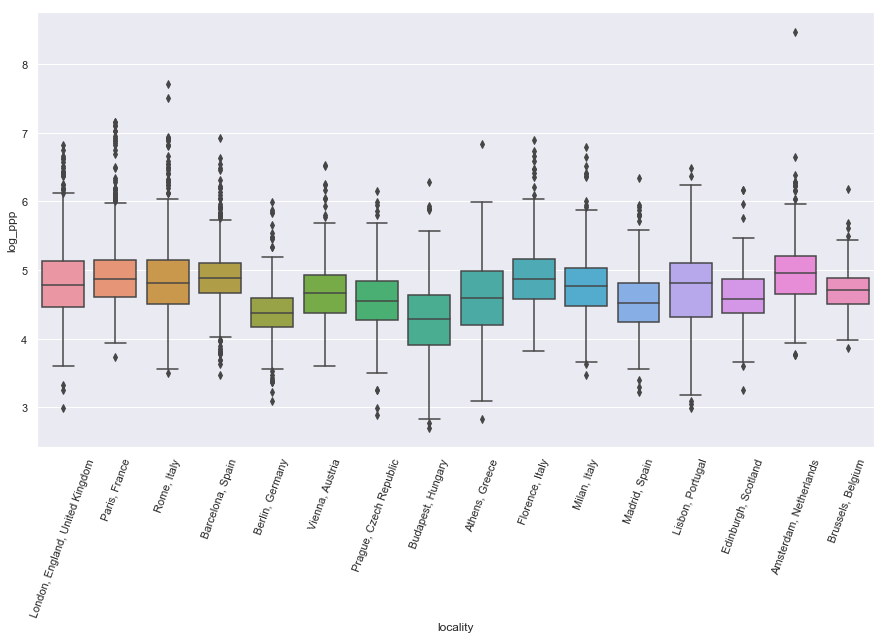

In [5]:
sns.set(rc={'figure.figsize':(15, 8)})
box_fig = sns.boxplot(x="locality", y="log_ppp", data=tadata)
box_fig.set_xticklabels(tadata.locality.unique(), rotation=70)

The log transformation of 'price_per_night' helped in getting the distribution to appear more normally distributed. There are still some cities with many outliers in the higher price range.

In [6]:
tadata1 = tadata.groupby(['locality', 'tripadvisor_rating'])
grouped1 = tadata1['price_per_night'].agg(np.mean).round(2)
grouped1 = grouped1.unstack(level=-1)
grouped1

tripadvisor_rating,3.0,3.5,4.0,4.5,5.0
locality,,,,,
"Amsterdam, Netherlands",124.85,123.78,174.90,197.56,303.38
"Athens, Greece",63.22,66.81,124.49,145.19,140.49
"Barcelona, Spain",110.58,116.58,132.45,170.79,246.02
"Berlin, Germany",NaN,71.49,79.42,107.25,131.33
"Brussels, Belgium",87.92,97.76,125.60,135.75,127.21
"Budapest, Hungary",48.26,63.94,72.51,96.82,123.16
"Edinburgh, Scotland",80.09,89.32,96.04,125.41,132.14
"Florence, Italy",90.33,95.72,123.68,163.66,206.68
"Lisbon, Portugal",60.33,91.93,119.28,156.36,168.07


/Users/tzulungs/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


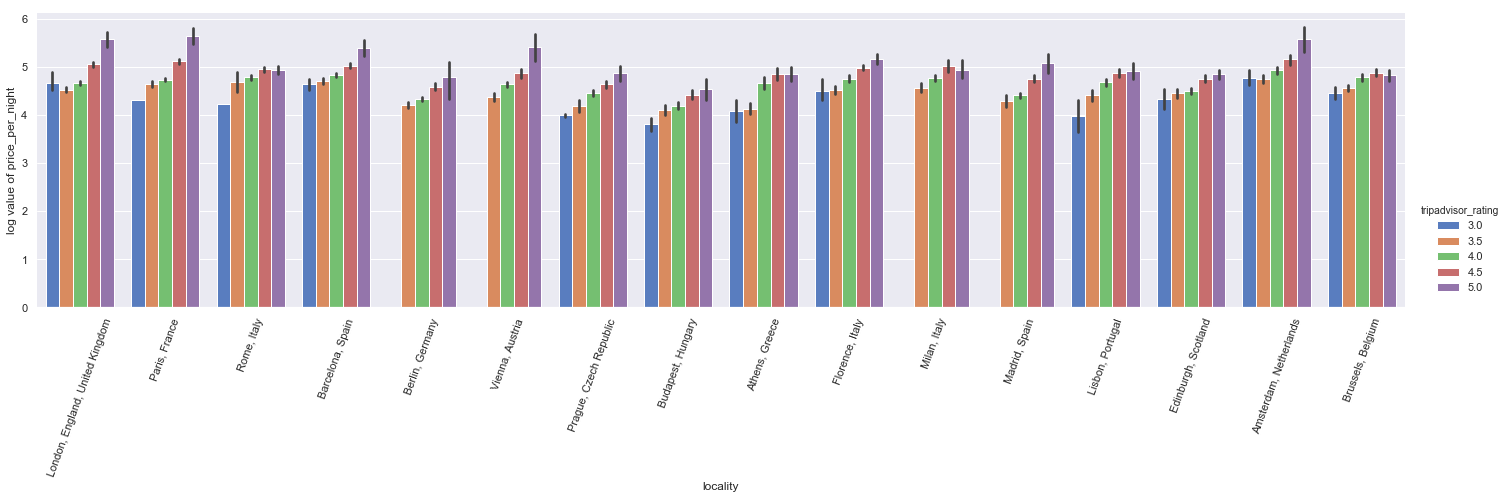

In [10]:
group_barplot1 = sns.catplot(x="locality", y="log_ppp", hue="tripadvisor_rating", data=tadata, kind="bar", height=5, aspect=4, palette="muted")
group_barplot1.despine(left=True)
group_barplot1.set_ylabels("log value of price_per_night")
group_barplot1.set_xticklabels(tadata.locality.unique(), rotation=70)


Looking at the barplot of the average log price per night grouped by cities, the data confirms that hotels with higher ratings have higher nightly room rates.

In [7]:
grouped2 = tadata1['hotel_name'].count()
grouped2 = grouped2.unstack(level=-1)
grouped2

tripadvisor_rating,3.0,3.5,4.0,4.5,5.0
locality,,,,,
"Amsterdam, Netherlands",20.0,85.0,150.0,93.0,16.0
"Athens, Greece",9.0,54.0,72.0,68.0,37.0
"Barcelona, Spain",45.0,123.0,268.0,239.0,40.0
"Berlin, Germany",NaN,82.0,237.0,158.0,6.0
"Brussels, Belgium",13.0,54.0,85.0,44.0,14.0
"Budapest, Hungary",27.0,51.0,126.0,147.0,44.0
"Edinburgh, Scotland",11.0,38.0,107.0,111.0,35.0
"Florence, Italy",3.0,47.0,106.0,233.0,95.0
"Lisbon, Portugal",9.0,70.0,165.0,166.0,72.0


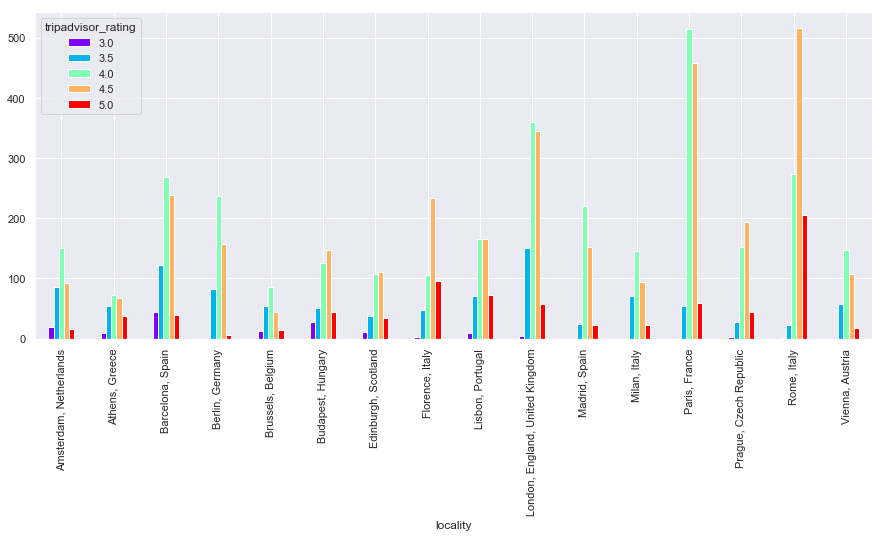

In [8]:
grouped2.plot.bar(figsize=(15, 6), cmap=plt.cm.rainbow)

The plot above shows that hotels are not evenly distributed among the cities in the dataset collected. Keeping this in mind as results of the recommender system could have more hotels from cities that have relatively more hotels from this dataset.

no_of_deals         (0, 5]  (5, 10]  (10, 15]  (15, 20]
tripadvisor_rating                                     
3.0                 106.00    97.13     85.31    104.20
3.5                  97.52    87.50     97.00    110.83
4.0                  98.24   110.14    114.16    136.50
4.5                 119.40   127.84    169.42    217.66
5.0                 138.76   173.66    260.72    420.22


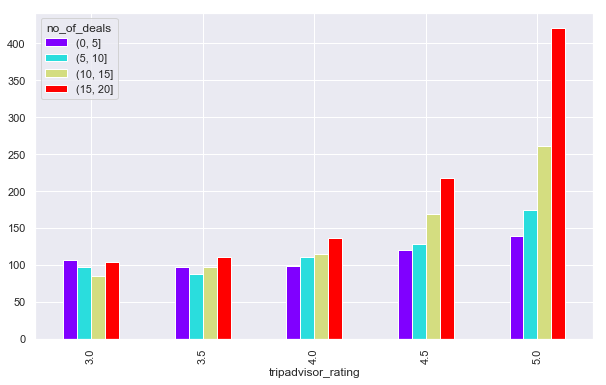

In [9]:
tadata2 = tadata.groupby(["tripadvisor_rating", pd.cut(tadata["no_of_deals"], np.arange(0, 25, 5))])
grouped3 = tadata2['price_per_night'].agg(np.mean).round(2)
grouped3 = grouped3.unstack(level=1)
print(grouped3)
grouped3.plot.bar(figsize=(10, 6), cmap=plt.cm.rainbow)

When considering only the ratings of hotel, there is less price variation for hotels with ratings less than 4.0. The nightly room rates of hotels with more number of deals advertised in the website are higher for hotels with rating of 4.5 and 5.0 than hotels with less number of deals. This could be deal to higher demand for and limited supply of rooms of 4.5 and 5.0 rated hotels, especially during peak tourist season during the summer.

In [168]:
tahotel = pd.read_json('tripadvisor_hotel.json')
tahotel.head()

,address,amenities,hotel_url,name,rank,hotel_rating,ratings,review_count
0,"{'street_address': '15 Montague Street', 'regi...","[Room service, Restaurant, Free High Speed Int...",http://www.tripadvisor.com/Hotel_Review-g18633...,The Montague on The Gardens,"#5 of 1,116 Hotels in London",5.0,"{'Excellent': '3,984', 'Good': '691', 'Average...",4821
1,"{'street_address': '20 Middlesex Street', 'reg...","[Restaurant, Bar/Lounge, Breakfast Available, ...",http://www.tripadvisor.com/Hotel_Review-g18633...,Travelodge London City hotel,"#100 of 1,116 Hotels in London#100 of 1,116 Ho...",4.5,"{'Excellent': '553', 'Good': '199', 'Average':...",809
10,"{'street_address': '5 Lower Belgrave Street', ...","[Bar/Lounge, Free High Speed Internet (WiFi), ...",http://www.tripadvisor.com/Hotel_Review-g18633...,The Z Hotel Victoria,"#423 of 1,116 Hotels in London#423 of 1,116 Ho...",4.0,"{'Excellent': '724', 'Good': '791', 'Average':...",1900
100,{'street_address': '16-22 Gunterstone Road Wes...,"[Free High Speed Internet (WiFi), Breakfast in...",http://www.tripadvisor.com/Hotel_Review-g18633...,The W14 Kensington,"#302 of 1,116 Hotels in London#302 of 1,116 Ho...",4.0,"{'Excellent': '664', 'Good': '728', 'Average':...",1755
1000,"{'street_address': '35 rue Benjamin Franklin',...","[Free High Speed Internet (WiFi), Bar/Lounge, ...",http://www.tripadvisor.com/Hotel_Review-g18714...,Hotel Eiffel Trocadero,"#640 of 1,829 Hotels in Paris",4.0,"{'Excellent': '189', 'Good': '137', 'Average':...",416


In [169]:
# cleaning tripadvisor_hotel.json
# further separate the address column into street address, locality, country and zipcode, and drop irrelevant columns
tahotel = pd.concat([tahotel.drop(['address'], axis=1), tahotel['address'].apply(pd.Series)], axis=1)
tahotel.drop('region', axis=1, inplace=True)

# make new columns from the dictionary of values in the ratings column and converting it to integers
tahotel = pd.concat([tahotel.drop(['ratings'], axis=1), tahotel['ratings'].apply(pd.Series)], axis=1)
tahotel['Excellent'] = tahotel['Excellent'].apply(lambda x: str(x).replace(',', ''))
tahotel['Good'] = tahotel['Good'].apply(lambda x: str(x).replace(',', ''))
tahotel['Average'] = tahotel['Average'].apply(lambda x: str(x).replace(',', ''))
tahotel['Poor'] = tahotel['Poor'].apply(lambda x: str(x).replace(',', ''))
tahotel['Terrible'] = tahotel['Terrible'].apply(lambda x: str(x).replace(',', ''))

tahotel['Excellent'] = tahotel.Excellent.astype('int64', errors='ignore')
tahotel['Good'] = tahotel.Good.astype('int64', errors='ignore')
tahotel['Average']= tahotel.Average.astype('int64', errors='ignore')
tahotel['Poor'] = tahotel.Poor.astype('int64', errors='ignore')
tahotel['Terrible'] = tahotel.Terrible.astype('int64', errors='ignore')

# get dummy variables from amenities column
tahotel = pd.concat([tahotel.drop('amenities', axis=1), pd.get_dummies(tahotel['amenities'].apply(pd.Series).stack()).sum(level=0)], axis=1)

tahotel.head()

,hotel_url,name,rank,hotel_rating,review_count,street_address,locality,country,zipcode,Excellent,...,Room service,Sauna,Self-Serve Laundry,Shuttle Bus Service,Ski-In / Ski-Out,Smoking rooms available,Spa,Suites,Tennis Court,Wheelchair access
0,http://www.tripadvisor.com/Hotel_Review-g18633...,The Montague on The Gardens,"#5 of 1,116 Hotels in London",5.0,4821,15 Montague Street,London,United Kingdom,WC1B 5BJ,3984,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,http://www.tripadvisor.com/Hotel_Review-g18633...,Travelodge London City hotel,"#100 of 1,116 Hotels in London#100 of 1,116 Ho...",4.5,809,20 Middlesex Street,London,United Kingdom,E1 7EX,553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,http://www.tripadvisor.com/Hotel_Review-g18633...,Park Plaza Westminster Bridge London,"#290 of 1,116 Hotels in London",4.5,20500,200 Westminster Bridge Road,London,United Kingdom,SE1 7UT,11860,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,http://www.tripadvisor.com/Hotel_Review-g18633...,Park Grand London Kensington,"#36 of 1,116 Hotels in London",4.5,4146,33-37 Hogarth Road Kensington,London,United Kingdom,SW5 0QQ,2814,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,http://www.tripadvisor.com/Hotel_Review-g18633...,The Grosvenor Hotel,"#372 of 1,116 Hotels in London#372 of 1,116 Ho...",4.0,5539,101 Buckingham Palace Road,London,United Kingdom,SW1W 0SJ,2810,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [170]:
combined_hotel_reviews = pd.read_csv('tripadvisor_hotel_review.csv')
combined_hotel_reviews.head()

,uid,user_link,rating,hotel_link,date_of_stay,title,review_preview
0,JIT66,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,"Yet again, a wonderful experience!",We are frequent travelers and have stayed at t...
1,JIT66,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,March 2017,Delightful!,Perfect British hotel! Could not have been hap...
2,livinglifetothefull1,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Mix it Cocktail making,We really enjoyed this experience. Delphine wa...
3,JRD-DUT,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Never Ceases to Impress.,My third visit to the Montague and again I was...
4,JRD-DUT,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2017,Love this Hotel,My second visit to the Montague and feel compe...


In [171]:
# create unique ids for hotels and guest reviewers
combined_hotel_reviews = combined_hotel_reviews.assign(uid=(combined_hotel_reviews['user_link']).astype('category').cat.codes)
combined_hotel_reviews = combined_hotel_reviews.assign(hid=(combined_hotel_reviews['hotel_link']).astype('category').cat.codes)
# dropping off 3 columns
combined_hotel_reviews.drop(combined_hotel_reviews[['date_of_stay', 'title', 'review_preview']], axis=1, inplace=True)
combined_hotel_reviews.head()

,uid,user_link,rating,hotel_link,hid
0,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
1,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
2,32619,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
3,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
4,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407


In [172]:
combined_hotel_reviews['hotel_link'].isin(tahotel['hotel_url']).value_counts()

True     57705
False        1
Name: hotel_link, dtype: int64

In [173]:
new_hotels = combined_hotel_reviews[~combined_hotel_reviews['hotel_link'].isin(tahotel['hotel_url']).dropna()]
print(len(new_hotels))
new_hotels.head()

1


,uid,user_link,rating,hotel_link,hid
13328,5837,http://www.tripadvisor.com/Profile/B4320GZdonnas,1.0,http://www.tripadvisor.com/Hotel_Review-g18779...,4139


In [174]:
# drop the one hotel in combined_hotel_reviews not found in tahotel
combined_hotel_reviews = combined_hotel_reviews.drop(combined_hotel_reviews.index[13328])

In [175]:
combined_hotel_reviews = combined_hotel_reviews.reset_index(drop=True)

In [176]:
# merge combined_hotel_reviews with information about hotel
combined_hotel_reviews = pd.merge(combined_hotel_reviews,
                 tahotel[['hotel_url', 'name', 'street_address', 'locality', 'country', 'hotel_rating']],
                 left_on='hotel_link',
                 right_on='hotel_url',
                 how='left')
combined_hotel_reviews = combined_hotel_reviews.drop(combined_hotel_reviews[['hotel_url']], axis=1)
combined_hotel_reviews.head()

,uid,user_link,rating,hotel_link,hid,name,street_address,locality,country,hotel_rating
0,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,15 Montague Street,London,United Kingdom,5.0
1,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,15 Montague Street,London,United Kingdom,5.0
2,32619,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,15 Montague Street,London,United Kingdom,5.0
3,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,15 Montague Street,London,United Kingdom,5.0
4,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,15 Montague Street,London,United Kingdom,5.0


## Recommender System with Surprise

In [177]:
# get dataframe into a format that is suitable for surprise library functions to process
grouped_combined_reviews = combined_hotel_reviews.groupby(['hid', 'uid'])
grouped_rating = grouped_combined_reviews[['rating']].agg(np.mean).round(2)
grouped_rating.reset_index(inplace=True)
grouped_rating.head()

,hid,uid,rating
0,0,2286,4.0
1,1,18661,4.0
2,2,10461,5.0
3,2,16121,5.0
4,2,34748,4.0


In [181]:
# transform dataframe into a surprise dataset variable
reader = Reader(rating_scale=(3, 5)) # Dataset only contains rating from 3 to 5
data = Dataset.load_from_df(grouped_rating[['uid', 'hid', 'rating']], reader)

In [182]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.958042,8.580609,0.358271
SVD,0.960877,2.878383,0.240901
KNNBaseline,0.961714,47.872000,0.615086
BaselineOnly,0.961817,0.262947,0.414617
KNNBasic,1.008431,48.164777,0.986282
CoClustering,1.030414,6.667057,0.171057
KNNWithMeans,1.060624,48.172343,0.486562
SlopeOne,1.060817,2.258531,0.288816
KNNWithZScore,1.061728,49.621662,0.562273


There are 4 models with rmse smaller than 1.0 which means that the mse is slightly smaller than the rmse value. Let's next use grid search on these 4 models and find the optimal parameters before selecting the best model.

In [48]:
# create a dataframe to record grid search results
grid_search_result = pd.DataFrame(columns=['algorithm', 'param_grid', 'best_rmse_score', 'best_params', 'test_prediction_rmse', 'fit_time'])

In [28]:
my_seed = 88
random.seed(my_seed)

raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)

# A_raw_rating is the training set which is 80% of the shuffled data
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings

In [63]:
print('Using SVDpp')

n_epochs = [23, 25, 27]
lr_all = [0.01]
reg_all = [0.15, 0.2, 0.25]

param_grid = {'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
gs1 = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5)
t0 = t.time()
gs1.fit(data)
t1 = t.time()
svdpp_lapsed = t1-t0

print(gs1.best_score['rmse'])
print(gs1.best_params['rmse'])

algo = gs1.best_estimator['rmse']

# retrain on the whole set
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy
svdpp_bpredictions = algo.test(trainset.build_testset())
print('Biased accuracy on the complete training set,', end='   ')
accuracy.rmse(svdpp_bpredictions)

# Compute unbiased accuracy using testset, B_raw_ratings
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
svdpp_upredictions = algo.test(testset)
print('Unbiased accuracy on the complete training set,', end=' ')
accuracy.rmse(svdpp_upredictions)

grid_search_result = grid_search_result.append({'algorithm':'SVDpp', 'param_grid':{'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}, 'best_rmse_score':gs1.best_score['rmse'], 'best_params':gs1.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(svdpp_upredictions), 'fit_time':svdpp_lapsed}, ignore_index=True)

Using SVDpp
0.9551989933720446
{'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.15}
Biased accuracy on the complete training set,   RMSE: 0.6133
Unbiased accuracy on the complete training set, RMSE: 0.9499
RMSE: 0.9499


In [65]:
print('KNN Baseline Using ALS and SGD')

method = ['als']
reg = [1]
k = [2, 3]
name = ['msd', 'cosine']
min_support = [2, 3, 4]
user_based = [False]

param_grid = {'bsl_options': {'method':method, 'reg':reg}, 'k':k, 'sim_options': {'name':name, 'min_support':min_support, 'user_based':user_based}}
gs2 = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5)
t0 = t.time()
gs2.fit(data)
t1 = t.time()
knnbl_lapsed = t1-t0

print(gs2.best_score['rmse'])
print(gs2.best_params['rmse'])

algo = gs2.best_estimator['rmse']

# retrain on the whole set
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy
knnbl_bpredictions = algo.test(trainset.build_testset())
print('Biased accuracy on the complete training set,', end='   ')
accuracy.rmse(knnbl_bpredictions)

# Compute unbiased accuracy using testset, B_raw_ratings
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
knnbl_upredictions = algo.test(testset)
print('Unbiased accuracy on the complete training set,', end=' ')
accuracy.rmse(knnbl_upredictions)

grid_search_result = grid_search_result.append({'algorithm':'KNNBaseline', 'param_grid':{'method':method, 'reg':reg}, 'k':k, 'sim_options': {'name':name, 'min_support':min_support, 'user_based':user_based}, 'best_rmse_score':gs2.best_score['rmse'], 'best_params':gs2.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(knnbl_upredictions), 'fit_time':knnbl_lapsed}, ignore_index=True)

KNN Baseline Using ALS and SGD
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Co

In [71]:
print('Using SVD')

n_epochs = [15, 20]
lr_all = [0.015, 0.02]
reg_all = [0.2]

param_grid = {'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}
gs3 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
t0 = t.time()
gs3.fit(data)
t1 = t.time()
svd_lapsed = t1-t0

print(gs3.best_score['rmse'])
print(gs3.best_params['rmse'])

algo = gs3.best_estimator['rmse']

# retrain on the whole set
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy
svd_bpredictions = algo.test(trainset.build_testset())
print('Biased accuracy on the complete training set,', end='   ')
accuracy.rmse(svd_bpredictions)

# Compute unbiased accuracy using testset, B_raw_ratings
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
svd_upredictions = algo.test(testset)
print('Unbiased accuracy on the complete training set,', end=' ')
accuracy.rmse(svd_upredictions)

grid_search_result = grid_search_result.append({'algorithm':'SVD', 'param_grid':{'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}, 'best_rmse_score':gs3.best_score['rmse'], 'best_params':gs3.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(svd_upredictions), 'fit_time':svd_lapsed}, ignore_index=True)

Using SVD
0.9547702181069966
{'n_epochs': 20, 'lr_all': 0.015, 'reg_all': 0.2}
Biased accuracy on the complete training set,   RMSE: 0.4297
Unbiased accuracy on the complete training set, RMSE: 0.9498
RMSE: 0.9498


In [54]:
print('Baseline Only Using ALS and SGD')

method = ['als', 'sgd']
reg = [1, 2]
k = [1, 2, 3]

param_grid = {'bsl_options': {'method':method, 'reg':reg, 'k': k}}
gs4 = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae'], cv=5)
t0 = t.time()
gs4.fit(data)
t1 = t.time()
blo_lapsed = t1-t0

print(gs4.best_score['rmse'])
print(gs4.best_params['rmse'])

algo = gs4.best_estimator['rmse']

# retrain on the whole set
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy
blo_bpredictions = algo.test(trainset.build_testset())
print('Biased accuracy on the complete training set,', end='   ')
accuracy.rmse(blo_bpredictions)

# Compute unbiased accuracy using testset, B_raw_ratings
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
blo_upredictions = algo.test(testset)
print('Unbiased accuracy on the complete training set,', end=' ')
accuracy.rmse(blo_upredictions)

grid_search_result = grid_search_result.append({'algorithm':'BaselineOnly', 'param_grid':{'method':method, 'reg':reg, 'k': k}, 'best_rmse_score':gs4.best_score['rmse'], 'best_params':gs4.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(blo_upredictions), 'fit_time':blo_lapsed}, ignore_index=True)

Baseline Only Using ALS and SGD
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimat

In [72]:
grid_search_result.head(15)

,algorithm,param_grid,best_rmse_score,best_params,test_prediction_rmse,fit_time,k,sim_options
0,SVDpp,"{'n_epochs': [15, 25, 35], 'lr_all': [0.001, 0...",0.955023,"{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.3}",0.948148,1300.740642,NaN,NaN
1,KNNBaseline,"{'method': ['als', 'sgd'], 'reg': [1, 2]}",0.961636,"{'bsl_options': {'method': 'als', 'reg': 1}, '...",0.957737,720.288805,"[5, 10, 15]","{'name': ['msd', 'cosine'], 'min_support': [1,..."
2,SVD,"{'n_epochs': [15, 25, 35], 'lr_all': [0.001, 0...",0.956109,"{'n_epochs': 15, 'lr_all': 0.02, 'reg_all': 0.3}",0.949329,484.458254,NaN,NaN
3,BaselineOnly,"{'method': ['als', 'sgd'], 'reg': [1, 2], 'k':...",0.961268,"{'bsl_options': {'method': 'als', 'reg': 1, 'k...",0.957737,21.641053,NaN,NaN
4,SVDpp,"{'n_epochs': [20, 25, 30], 'lr_all': [0.005, 0...",0.954512,"{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.2}",0.948766,1280.002566,NaN,NaN
5,KNNBaseline,"{'method': ['als', 'sgd'], 'reg': [1, 2]}",0.961786,"{'bsl_options': {'method': 'als', 'reg': 1}, '...",0.957737,976.422600,"[2, 3, 4, 5]","{'name': ['msd', 'cosine'], 'min_support': [3,..."
6,SVD,"{'n_epochs': [10, 15, 20], 'lr_all': [0.015, 0...",0.954524,"{'n_epochs': 20, 'lr_all': 0.015, 'reg_all': 0.2}",0.950452,306.782222,NaN,NaN
7,SVDpp,"{'n_epochs': [23, 25, 27], 'lr_all': [0.01], '...",0.955199,"{'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.15}",0.949908,443.204460,NaN,NaN
8,KNNBaseline,"{'method': ['als'], 'reg': [1]}",0.961361,"{'bsl_options': {'method': 'als', 'reg': 1}, '...",0.957737,117.591440,"[2, 3]","{'name': ['msd', 'cosine'], 'min_support': [2,..."
9,SVD,"{'n_epochs': [18, 20, 22], 'lr_all': [0.015, 0...",0.955152,"{'n_epochs': 18, 'lr_all': 0.015, 'reg_all': 0...",0.949811,258.662503,NaN,NaN


Given that both the SVD and SVDpp have almost similar rmse scores with SVDpp outperforming slightly in test predictions, it would be a good call to pick SVD for SVDpp takes more than twice as long to fit and is in the long run more expensive to update.

In [73]:
# Dump best algorithm and reload it.
file_name = os.path.expanduser('surprise_SVD_model')
dump.dump(file_name, algo=algo)
_, loaded_algo = dump.load(file_name)


In [74]:
def get_top_n(predictions, n=10):
    
    '''
    
    Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
        
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [180]:
# First train an SVD algorithm
data = Dataset.load_from_df(grouped_rating[['uid', 'hid', 'rating']], reader)
trainset = data.build_full_trainset()
algo = loaded_algo
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

In [ ]:
# saving the predicted top 10 recommendations of the SVD model with pickle
with open("Top_Predictions", wb) as tp:
    pickle.dump(top_n, tp)

In [5]:
top_n = pd.read_pickle("./Top_Predictions")

In [166]:
# getting all hotels that a particular user reviewed
combined_hotel_reviews.loc[combined_hotel_reviews["uid"] == 20692][[ "name", "street_address", "locality", "hotel_link"]].reset_index(drop = True)

,name,street_address,locality,hotel_link
0,Made In Louise,Rue Veydt 40,Ixelles,http://www.tripadvisor.com/Hotel_Review-g11364...
1,Hotel Palazzo Zichy,Lorinc pap ter 2,Budapest,http://www.tripadvisor.com/Hotel_Review-g27488...
2,Vincci Baixa,"Rua Do Comercio, 32 a 38 Rua Do S.Juliao, no 4...",Lisbon,http://www.tripadvisor.com/Hotel_Review-g18915...


In [63]:
# getting the top 10 recommendations for a particular user
top_picks = top_n[20692]
hotels, _ = zip(*top_picks)
top_suggestions = pd.DataFrame(columns = ["name", "street_address", "locality", "hotel_link"])
for hotel in hotels:
    top_suggestions = top_suggestions.append(combined_hotel_reviews.loc[combined_hotel_reviews["hid"] == hotel][[ "name", "street_address", "locality", "hotel_link"]], ignore_index = True)

top_suggestions.drop_duplicates(keep = 'last').reset_index(drop = True)

,name,street_address,locality,hotel_link
0,La Ballerina,Dittrichova 20,Prague,http://www.tripadvisor.com/Hotel_Review-g27470...
1,Hotel 41,41 Buckingham Palace Road,London,http://www.tripadvisor.com/Hotel_Review-g18633...
2,San Giuliano Inn,Via Camillo Benso Cavour 33,,http://www.tripadvisor.com/Hotel_Review-g18789...
3,Emporikon Athens Hotel,"27, Aiolou Street Plaka",,http://www.tripadvisor.com/Hotel_Review-g18940...
4,Martinhal Lisbon Chiado Family Suites,Rua das Flores 44,Lisbon,http://www.tripadvisor.com/Hotel_Review-g18915...
5,H10 Madison,"C/ Dr. Joaquim Pou, 2-4-6",Barcelona,http://www.tripadvisor.com/Hotel_Review-g18749...
6,Four Seasons Hotel Gresham Palace,Szechenyi Istvan Ter 5 - 6,Budapest,http://www.tripadvisor.com/Hotel_Review-g27488...
7,The Soho Hotel,4 Richmond Mews,London,http://www.tripadvisor.com/Hotel_Review-g18633...
8,InnAthens,Georgiou Souri 3 Filellinon,,http://www.tripadvisor.com/Hotel_Review-g18940...
9,Residence Hilda,Via Dei Servi 40 San Marco - Santissima Annunz...,,http://www.tripadvisor.com/Hotel_Review-g18789...


It is difficult to evaluate if this model gives decent recommendations as the dataset only contains hotels of ratings 3 to 5. Hotels of lower ratings are excluded as my initial thought process is that the recommender should only recommend hotels with 3 or above ratings. That said, there is definitely room for improving the model. The hotels recommended should have many of the hotel features that the user stayed before and the room rates are within a reasonable price range that the user previous paid. 